In [7]:
import pandas as pd
from reviews.config import processed_data_dir

In [8]:
#load data
prod_df = pd.read_json(processed_data_dir / "meta_digital_cameras.json.gz")
reviews_df = pd.read_json(processed_data_dir / "reviews_digital_cameras.json.gz")   

In [9]:
# merge data (inner mode) 
data_df = pd.merge(left=prod_df, right=reviews_df, on='asin')
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87205 entries, 0 to 87204
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     87205 non-null  object
 1   description  87205 non-null  object
 2   title        87205 non-null  object
 3   brand        87205 non-null  object
 4   main_cat     87205 non-null  object
 5   date         87205 non-null  object
 6   price        87205 non-null  object
 7   asin         87205 non-null  object
 8   overall      87205 non-null  int64 
 9   vote         87205 non-null  int64 
 10  text         87205 non-null  object
 11  summary      87205 non-null  object
 12  timestamp    87205 non-null  int64 
dtypes: int64(3), object(10)
memory usage: 6.0+ MB


In [10]:
#head of merge data
data_df.head(10)

,category,description,title,brand,main_cat,date,price,asin,overall,vote,text,summary,timestamp
0,"[Electronics, Camera & Photo, Digital Cameras,...","[Digital camera 640x480 resolution, 2MB built ...",Agfa ePhoto SMILE 0.2MP Digital Camera,Agfa,Camera & Photo,"January 11, 2001",,B00000JBIA,1,47,"I bought the Smile to have a handy, inexpensiv...",Not the best choice,950
1,"[Electronics, Camera & Photo, Digital Cameras,...","[Digital camera 640x480 resolution, 2MB built ...",Agfa ePhoto SMILE 0.2MP Digital Camera,Agfa,Camera & Photo,"January 11, 2001",,B00000JBIA,1,24,It is absolutely useless. The pictures are gr...,This camera is HORRIBLE!,971
2,"[Electronics, Camera & Photo, Digital Cameras,...","[Digital camera 640x480 resolution, 2MB built ...",Agfa ePhoto SMILE 0.2MP Digital Camera,Agfa,Camera & Photo,"January 11, 2001",,B00000JBIA,4,73,Bought one from Amazon and begun immediately t...,What do you need?,966
3,"[Electronics, Camera & Photo, Digital Cameras,...","[Digital camera 640x480 resolution, 2MB built ...",Agfa ePhoto SMILE 0.2MP Digital Camera,Agfa,Camera & Photo,"January 11, 2001",,B00000JBIA,1,28,"I'm on a small budget this summer, so I bought...","Worse than I thought, but at that price...",960
4,"[Electronics, Camera & Photo, Digital Cameras,...","[Digital camera 640x480 resolution, 2MB built ...",Agfa ePhoto SMILE 0.2MP Digital Camera,Agfa,Camera & Photo,"January 11, 2001",,B00000JBIA,3,109,My first experiences with AGFA cameras were in...,Not bad for the money,959
5,"[Electronics, Camera & Photo, Digital Cameras,...","[Digital camera 640x480 resolution, 2MB built ...",Agfa ePhoto SMILE 0.2MP Digital Camera,Agfa,Camera & Photo,"January 11, 2001",,B00000JBIA,1,5,I bought two of these for my kids and they are...,Just awful; avoid at all costs,986
6,"[Electronics, Camera & Photo, Digital Cameras,...","[Digital camera 640x480 resolution, 2MB built ...",Agfa ePhoto SMILE 0.2MP Digital Camera,Agfa,Camera & Photo,"January 11, 2001",,B00000JBIA,1,0,It's a nice little TOY. That's all it is. It...,Sold it for $40...I think I ripped the guy off.,978
7,"[Electronics, Camera & Photo, Digital Cameras,...",[Boosts productivity while improving your imag...,Kodak DC240 1.2MP Digital Camera w/ 3x Optical...,Kodak,Camera & Photo,"September 4, 1999",,B00000JDEL,4,3,I really like mine. It takes good pictures. It...,Kodak 240,971
8,"[Electronics, Camera & Photo, Digital Cameras,...",[Boosts productivity while improving your imag...,Kodak DC240 1.2MP Digital Camera w/ 3x Optical...,Kodak,Camera & Photo,"September 4, 1999",,B00000JDEL,5,4,This is the best camera I have seen for the pr...,"Great Camera, Great Features, Easy Use",969
9,"[Electronics, Camera & Photo, Digital Cameras,...",[Boosts productivity while improving your imag...,Kodak DC240 1.2MP Digital Camera w/ 3x Optical...,Kodak,Camera & Photo,"September 4, 1999",,B00000JDEL,4,10,"I have been in photography for about 15 years,...",Great Camera for the price!,965


In [11]:
print(data_df.groupby("asin")["overall"].mean())

asin
B00000JBIA    1.714286
B00000JDEL    4.400000
B00000JFIF    4.833333
B00000JYLO    3.928571
B00000JYWQ    4.111111
                ...   
B01GKNUGHC    4.666667
B01H65ESKY    4.375000
B01HDQBSR2    4.333333
B01HH8H2WQ    4.777778
B01HHR572O    3.833333
Name: overall, Length: 2189, dtype: float64


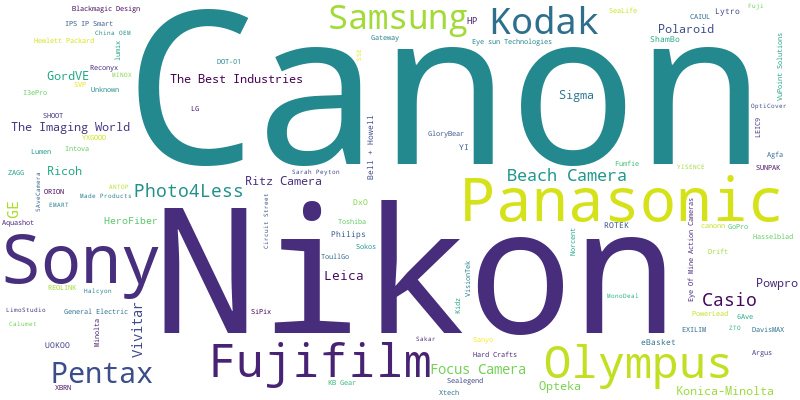

In [18]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud


# brand con maggiori recensioni
c = Counter(list(data_df['brand']))
w = WordCloud(width=800, height=400, background_color="white").fit_words(c)
w.to_image()

In [29]:
# mean valuation for brand
print((data_df.groupby("brand")["overall"].mean()).sort_values())

brand
Agfa                    1.714286
Sakar                   2.000000
Eye sun Technologies    2.142857
Argus                   2.384615
SeaLife                 2.400000
                          ...   
I3ePro                  4.937500
The Best Industries     4.970370
OptiCover               5.000000
MonoDeal                5.000000
Circuit Street          5.000000
Name: overall, Length: 109, dtype: float64


In [32]:
# mean number of util vote for brand
print((data_df.groupby("brand")["vote"].mean()).sort_values())

brand
Made Products     0.000000
canonn            0.000000
MonoDeal          0.000000
Halcyon           0.000000
Fumfie            0.000000
                   ...    
Fuji             17.400000
Hasselblad       19.000000
Leica            20.950495
LEIC9            30.818182
Agfa             40.857143
Name: vote, Length: 109, dtype: float64
